# GDP Machine Learning Model
### Ravi Shankar

27 March 2022

GDP is an important indicator of economic activity in a nation. GDP is the sum of values (in USD) of good and services produced in a nation during a year, including net exports. The GDP per capita (The GDP of a nation divided by its population) varies significantly among countries of the world, and is a key indicator of standard of living. Here we use nominal GDP, which is not adjusted by the prices in each country.

We want to find a model to see what factors correlate with GDP per capita. 

**Data comes via the World Bank, and the data across all listed countries was taken from 2018** because that was the most complete and recent year.

Worldbank's [GDP](https://data.worldbank.org/indicator/Ny.Gdp.Mktp.Cd) data will be compared with these other indexes:

- [Population](https://data.worldbank.org/indicator/SP.POP.TOTL)
- [Number secure internet servers/ million people](https://data.worldbank.org/indicator/IT.NET.SECR.P6)
- [Exports (as percentage of GDP)](https://data.worldbank.org/indicator/NE.EXP.GNFS.ZS)
- [Imports (as percentage of GDP)](https://data.worldbank.org/indicator/NE.IMP.GNFS.ZS?view=chart)

We will create a [Regression Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) to see which features best seperate GDP per capita and tease out any trends or relationships between the features. This is an example of explanatory modelling. 

This model will also give us the ability to predict GDP. If there was a hypothetical new country where we knew their population, what percentage of their GDP is imports/exports, and their number of internet servers, then we would have a data-based estimate of what their GDP would be.

# Import Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [2]:
GDPDF = pd.read_csv("Data/GDP_attributes.csv")

#Drop countries with any NaNs in the data
length_before_drop = len(GDPDF)
GDPDF = GDPDF.dropna()
#reset indices
GDPDF =GDPDF.reset_index()
GDPDF = GDPDF.drop("index", axis =1)

print("Number rows dropped due to NaN's: ", length_before_drop-len(GDPDF))


#Rename column features
GDPDF.columns = ["Country Name", "GDP", "Internet", "Exports", "Imports", "Population" ]

#Add GDP per Capita Feature
GDPDF["GDPpC"] = GDPDF["GDP"]/GDPDF["Population"]

GDPDF

Number rows dropped due to NaN's:  34


,Country Name,GDP,Internet,Exports,Imports,Population,GDPpC
0,Aruba,3.202189e+09,1152.617954,73.799397,74.626405,1.058460e+05,30253.279359
1,Africa Eastern and Southern,9.866110e+11,1164.559933,26.732987,29.070033,6.430901e+08,1534.172198
2,Africa Western and Central,7.381310e+11,89.707350,21.468395,23.620981,4.352294e+08,1695.958573
3,Angola,1.013530e+11,11.197741,40.836290,25.541821,3.080979e+07,3289.636504
4,Albania,1.514702e+10,526.099856,31.591574,45.264314,2.866376e+06,5284.380184
...,...,...,...,...,...,...,...
227,World,8.613930e+13,6171.416896,29.239847,28.514729,7.592476e+09,11345.350893
228,Samoa,8.214961e+08,535.364660,34.181263,50.224796,1.961280e+05,4188.571058
229,South Africa,3.682890e+11,12031.591630,29.907083,29.563251,5.779252e+07,6372.606697
230,Zambia,2.631164e+10,41.206304,37.957353,36.930894,1.735171e+07,1516.371100


# EDA

First let us create a boxplot to  visualize the spread of all the nations with complete data's GDP/capita (232 total):


Mean GDP of all countries recorded:  15746.01
Median GDP of all countries recorded:  6833.83

Left Whisker :  -23442.87441784389
Q1 quantile of GDP/capita :  2152.618376651528
Q3 quantile of GDP/capita :  19216.280239648473
Right Whisker :  44811.77303414389


271.7524963582891

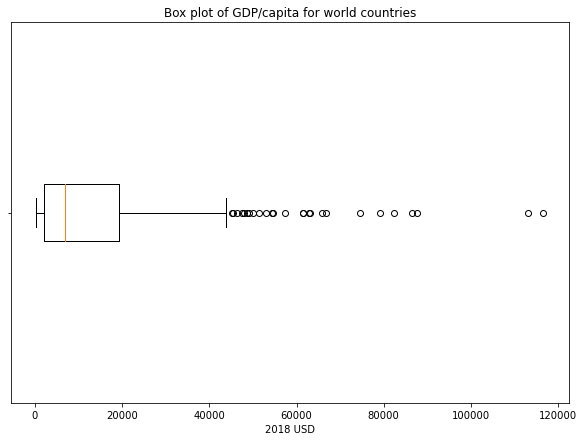

In [3]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np

#ref: https://www.geeksforgeeks.org/box-plot-in-python-using-matplotlib/
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
# Creating dataset, data = GDP per capita for 238 countries
data = GDPDF.GDPpC

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111)
 
# Creating axes instance (horizontal box plot)
bp = ax.boxplot(data, vert = 0)

# x-axis labels
ax.set_yticklabels([''])
ax.set_xlabel('2018 USD')
    
# Adding title
plt.title("Box plot of GDP/capita for world countries")

mean_GDP = np.mean(data)
median_GDP = np.median(data)

print("Mean GDP of all countries recorded: ", round(mean_GDP,2))
print("Median GDP of all countries recorded: ", round(median_GDP,2))
print()

#Whiskers are calculated as Q1 - 1.5*IQR or Q3 + 1.5*IQR (see matplotlib documentation)
IQR = np.quantile(data, .75) - np.quantile(data, .25)
print("Left Whisker : ", np.quantile(data, .25)- 1.5*IQR)
print("Q1 quantile of GDP/capita : ", np.quantile(data, .25)) 
print("Q3 quantile of GDP/capita : ", np.quantile(data, .75)) 
print("Right Whisker : ", np.quantile(data, .75)+ 1.5*IQR)

np.quantile(data,0)


The world distribution of GDP/capita is very right skewed. There are many "outlier" countries higher than the 3rd Quartile, but there are not any lower than the first quartile. 

Another indication of the right skew is how much larger the mean is than the median:

Mean | Median
---|---
\$15,746.01 |$6,833.83

The Boxplot distributions is as follows:

Left Whisker | Q1 | Median| Q3 |Right Whisker
---|---|---|---|---
-\$23442.87 |\$2152.62|\$6,833.83|\$19,216.28|\$44811.77

Essentially, there are many "outlier" values on the right end with GDP/capita's of more than $44811.77, but none on the left end so the model should consider that when optimizing.

# GDP Predictive Regression Tree Model

Here we will fit a Regression Tree classifier to the GDP data using the sklearn package.

The optimal max `tree_depth` will be calculated using 5 fold validation for all possible depths.

Then the decision tree will be presented for guidance.

# Find optimum `tree_depth` through kfoldValidation

The hyperparameter we will choose to tune is `tree_depth.` This can be optimized, because when the `tree_depth` is too low, the tree model will underfit the data and give high bias. If the `tree_depth` is too high, the model will overfit to the training data and the variance of testing predictions will be too high.


5-fold validation will be done on each possible `tree_depth` (1 to 8 for this size of data). The average MSE (mean squared error) of the five folds will be plotted alongside `tree_depth` to find if there is an optimum

In [4]:
def kfoldValidate(X , y , model, folds = 5 ):
    '''
    input: X data (features), y data (target), a sklearn model
    output: the list of MSEs of that model when k-fold validated. list length  = num folds
    
    example: 
    @params: 
    depth (int): depth of the tree to fit a model to.
    '''
    
    import numpy as np
    from sklearn.model_selection import KFold
    from sklearn.metrics import mean_squared_error
    from sklearn.tree import DecisionTreeRegressor 
    
    
    
    kf = KFold(n_splits=folds, random_state=None, shuffle=False)
    kf.get_n_splits(X)
    #print(kf)
    
    MSE_list = []
    
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        
        #Create train-test splits
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Train Model 
        model = model.fit(X_train,y_train)
        
        #Test Model
        y_predicted = model.predict(X_test)
        
        #Return RMSD
        MSE = mean_squared_error(y_test, y_predicted)
        MSE_list.append(MSE)
        
    return MSE_list

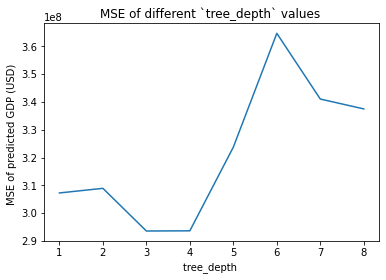

The minimum MSE value is:  293537383.4844372  at depth:  3


In [5]:
from sklearn.tree import DecisionTreeRegressor 

#Set up X and y
#X is 238 x 4 matrix
#y is 238 x 1 matrix

X = np.matrix(GDPDF.drop([ 'GDP','Country Name', 'GDPpC'], axis=1))
y = np.matrix( GDPDF.GDPpC )
y = y.reshape(-1, 1) 



#Get a RMSE from 5 fold validating on each tree_depth from 1 to 8
MSE_list = []
tree_depth_sizes = range(1,9)
#we will try 5-fold validation on 
for tree_depth in tree_depth_sizes:
    #Create Model
    regressor = DecisionTreeRegressor( random_state = 0,  max_depth = tree_depth) 

    model = regressor.fit(X, y)

    #################
    #5-fold validate#
    #################

    MSE_5_fold = kfoldValidate(X, y, regressor, folds =5) 
    #Append AVERAGE MSE over the 5 folds
    MSE_list.append(np.mean(MSE_5_fold) )


######
#PLOT#
######
# Adding title
plt.title("MSE of different `tree_depth` values ")
plt.xlabel("tree_depth ")
plt.ylabel("MSE of predicted GDP (USD) ")


plt.plot(tree_depth_sizes, MSE_list)
plt.show()

print("The minimum MSE value is: " , min(MSE_list), " at depth: " , 1+ MSE_list.index(min(MSE_list)))



The **optimal tree_depth to predict GDP per capita is 3**. At that depth, the prediction MSE was 293,537,383.48, which means there is a Root-Mean-Squared Deviation (RSMD) of  $17,132.93.

### Present Optimal decision tree regression model:



In [6]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn import tree
import matplotlib.pyplot as plt

#Decision tree with depth provided
#decision_tree = tree.DecisionTreeClassifier(max_depth = depth)

#Set up X and y
X = np.matrix(GDPDF.drop([ 'GDP','Country Name', 'GDPpC'], axis=1))

y = np.matrix( GDPDF.GDPpC )
y = y.reshape(-1, 1) 

#METHOD CALL:
regressor = DecisionTreeRegressor( random_state = 0,  max_depth = 3) 
# I would have liked to use absolute error instead of MSE, but couldn't get it to work
    
model = regressor.fit(X, y)

#Export a Prettier graph a la: https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/

# import export_graphviz
from sklearn.tree import export_graphviz 
  
# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
export_graphviz(regressor, out_file ='GDPtree.dot',
               feature_names =["Internet", "Exports", "Imports", "Population" ]) 

#NOTE: Graphviz exports


![GDPTree](./GDPtree2.png)

Note: graphviz exports a .dot file. To convert it to a .png to get the graph tree diagram as a picture, first install graphviz via anaconda prompt:

`conda install python-graphviz`

Then use the `dot` command after cd'ing to the folder to convert from .dot to .png:

`dot -Tpng GDPtree.dot -o GDPtree.png`

# Results

The **optimal tree_depth to predict GDP per capita was 3**, as found by 5-fold validation pictured above. At that depth, the prediction MSE was 293,537,383.48, and the **RMSD was $17,132.93.**

It was found that **internet servers per capita was the best feature for seperating GDP per capita.**

After that, population is the feature with the strongest effect on determining GDP per capita.

Also some nodes had only one sample, indicating outliers with unique combinations of statistics. For instance:
- 13 countries had over 42,700 internet servers/ million population, but only one country out of those had exports over 194% of their GDP (**Luxembourg**)
- 37 countries had between 8,112 and 42,748 internet servers/ million population, but only one country out of those had a population less than 223,495 (**Bermuda**)